In [2]:
import pandas as pd 
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

In [3]:
with open('./admission.txt', 'r') as f:
    reader = csv.reader(f)
    X = []
    y = []
    for row in reader:
        x1, x2, lbl = float(row[0]), float(row[1]), float(row[2])
        X.append([x1, x2])
        y.append(lbl)
X = np.array(X)
y = np.array(y)
 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

In [4]:
def classify(X, y, example, k):
    '''
    :param X: zbiór (uczący) danych postaci ndarray (m, n), gdzie m to liczba przykładów, a n liczba cech
    :param y: zbiór wartości (labels) w postaci wektora ndarray (m, ). Każdy z elementów ma wartość 0 lub 1
    :param example: wektor cech danego przykładu postaci ndarray (n, )
    :param k: parametr k algorytmu knn
    :return: predykcja klasy przykładu. 0 lub 1
    '''
    # 1. iteruj po wszystkich przykładach ze zbioru uczącego - X
    #     a. dla każdego z przykładów oblicz dystans między aktualnie rozważanym przykładem uczącym a przykładem example, który jest poddany klasyfikacji
    #     b. zapisz w kolekcji parę (dystans, klasa przykładu uczącego)
    # 2. posortuj kolekcję względem dystansów, rosnąco
    # 3. wybierz k pierwszych elementów (k najkrótszych dystansów)
    # 4. klasa rozważanego przykładu example będzie taka jak większość wśród k przykładów z najkrótszym dystansem
 
    # Obliczamy odległości euklidesowe między example a każdym punktem w X
    distances = np.linalg.norm(X - example, axis=1)

    # Tworzymy listę par (odległość, klasa)
    distances_with_labels = list(zip(distances, y))

    # Sortujemy według odległości rosnąco
    sorted_distances = sorted(distances_with_labels, key=lambda x: x[0])

    # Wybieramy k najbliższych sąsiadów
    nearest_neighbors = [label for _, label in sorted_distances[:k]]

    # Znajdujemy najczęściej występującą klasę wśród najbliższych sąsiadów
    most_common = Counter(nearest_neighbors).most_common(1)[0][0]

    return most_common


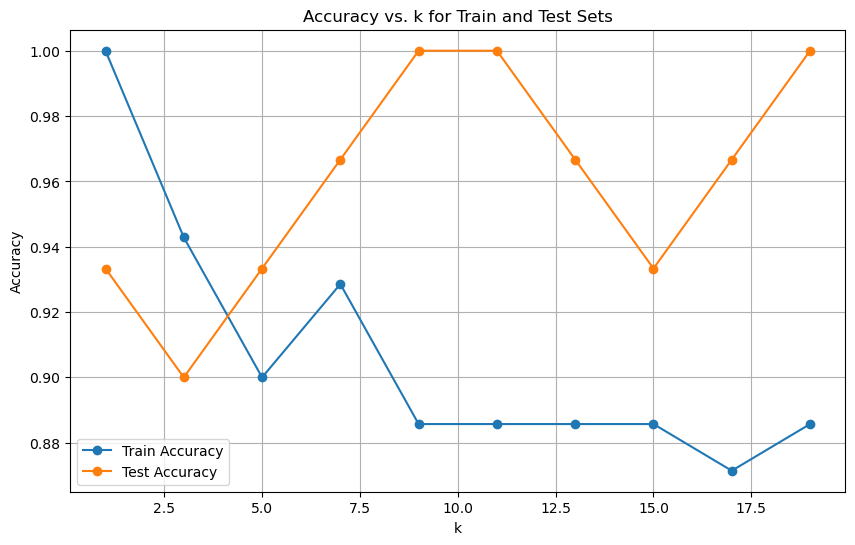

In [5]:
def calculate_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

k_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
test_accuracies = []
train_accuracies = []

# for k in [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]:
#     y_pred = np.zeros(y_test.shape)
#     for example_idx, example in enumerate(x_test):
#         pred = classify(x_train, y_train, example, k)
#         y_pred[example_idx] = pred

for k in k_values:
        y_train_pred = np.zeros(y_train.shape)
        y_test_pred = np.zeros(y_test.shape)

        for i, example in enumerate(x_train):
            y_train_pred[i] = classify(x_train, y_train, example, k)

        for i, example in enumerate(x_test):
            y_test_pred[i] = classify(x_train, y_train, example, k)

        train_accuracy = calculate_accuracy(y_train, y_train_pred)
        test_accuracy = calculate_accuracy(y_test, y_test_pred)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

# Wykres skuteczności względem k
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(k_values, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k for Train and Test Sets')
plt.legend()
plt.grid(True)
plt.show()



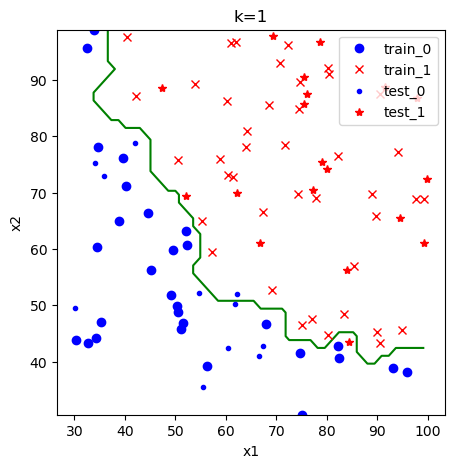

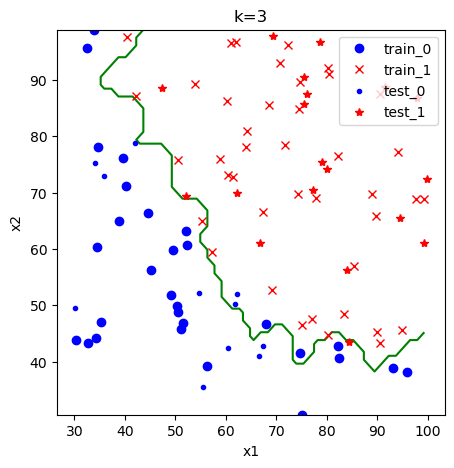

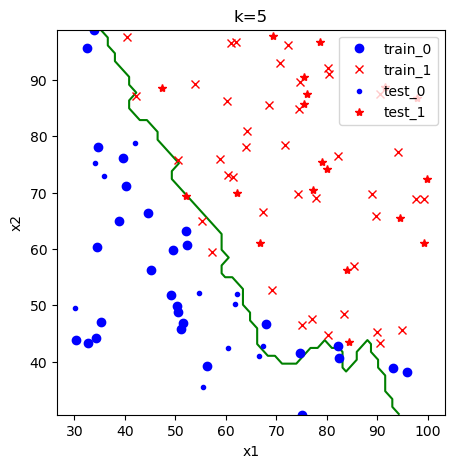

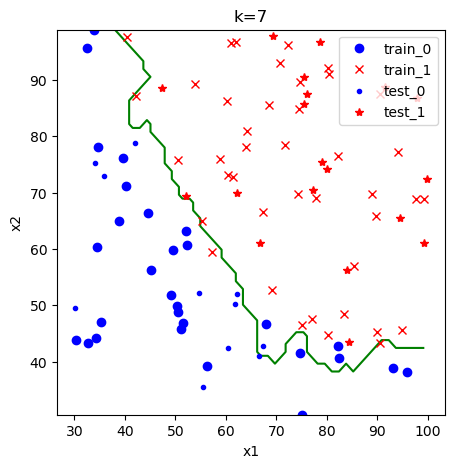

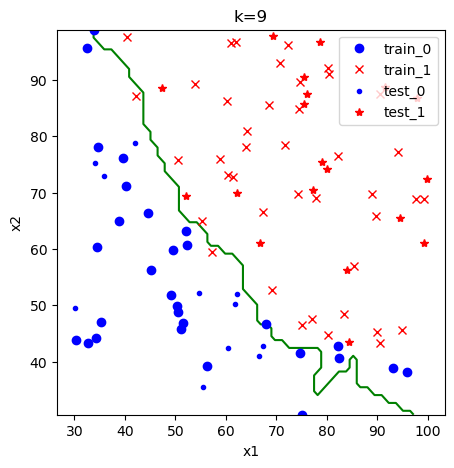

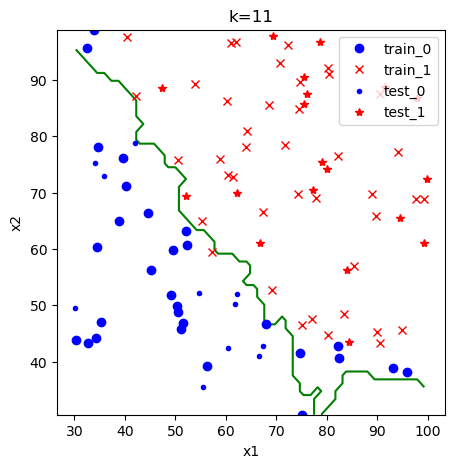

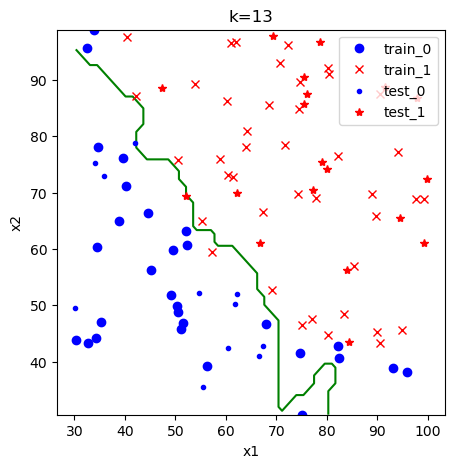

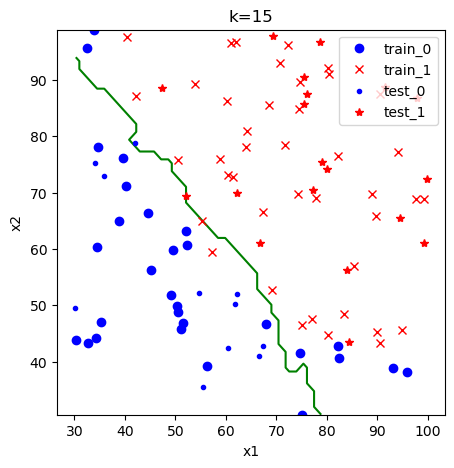

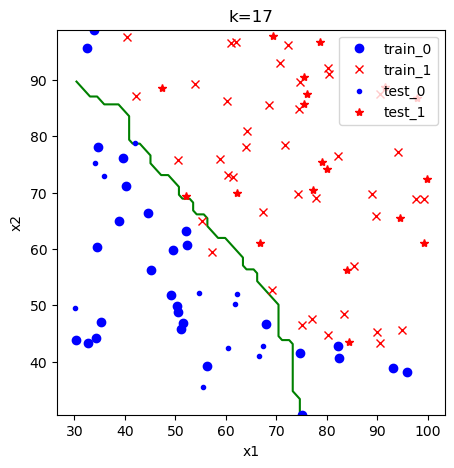

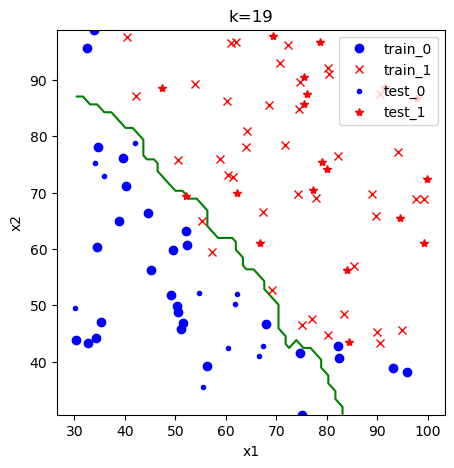

In [6]:
for k in k_values:
    # setup plot
    plt.figure(figsize=(5, 5))
    plt.title(f'k={k}')
    plt.xlabel('x1')
    plt.ylabel('x2')

    # prepare data for contour plot
    x1_res = 50
    x2_res = 50
    x1 = np.linspace(x_train[:, 0].min(), x_train[:, 0].max(), x1_res)
    x2 = np.linspace(x_train[:, 1].min(), x_train[:, 1].max(), x2_res)
    x1x1, x2x2 = np.meshgrid(x1, x2)
    x1x2_range_comb = np.c_[x1x1.ravel(), x2x2.ravel()]
    labels_space = np.zeros((x1_res, x2_res))
    for row_idx in range(x2_res):
        for col_idx in range(x1_res):
            example = np.array([x1[col_idx], x2[row_idx]])
            pred = classify(x_train, y_train, example, k)
            labels_space[row_idx, col_idx] = pred
    # plot decision boundary
    plt.contour(x1x1, x2x2, labels_space, levels=[0.5], colors='g')

    # plot training set
    plt.plot(x_train[y_train == 0, 0], x_train[y_train == 0, 1], 'bo')
    plt.plot(x_train[y_train == 1, 0], x_train[y_train == 1, 1], 'rx')

    # plot test set
    plt.plot(x_test[y_test == 0, 0], x_test[y_test == 0, 1], 'b.')
    plt.plot(x_test[y_test == 1, 0], x_test[y_test == 1, 1], 'r*')

    plt.legend(['train_0', 'train_1', 'test_0', 'test_1'])

In [7]:
best_k = 9
best_test_accuracy = 0

def calculate_sensitivity_ppv(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    ppv = TP / (TP + FP) if (TP + FP) > 0 else 0
    accuracy = (TP + np.sum((y_true == 0) & (y_pred == 0))) / len(y_true)
    return sensitivity, ppv, accuracy

# Obliczanie SE i PP dla najlepszego k
y_test_pred_best = np.array([classify(x_train, y_train, example, best_k) for example in x_test])
sensitivity, ppv, accuracy = calculate_sensitivity_ppv(y_test, y_test_pred_best)

print(f"Najlepsze k: {best_k}")
print(f"Dokładność na zbiorze testowym: {accuracy}")
print(f"Czułość (SE): {sensitivity}")
print(f"Pozytywne przewidywanie (PP): {ppv}")

Najlepsze k: 9
Dokładność na zbiorze testowym: 1.0
Czułość (SE): 1.0
Pozytywne przewidywanie (PP): 1.0


# Badanie dla klasyfiaktora wbudowanaego z sklearn

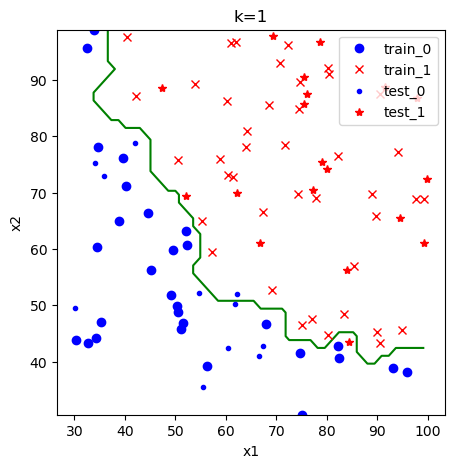

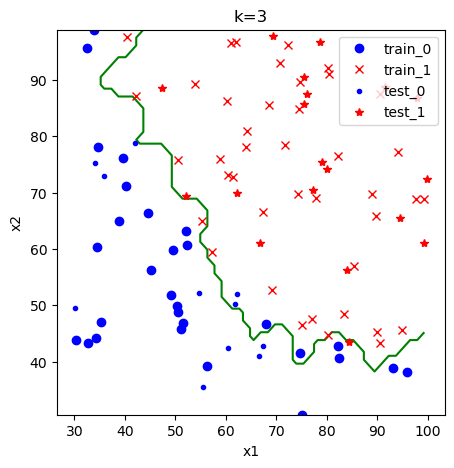

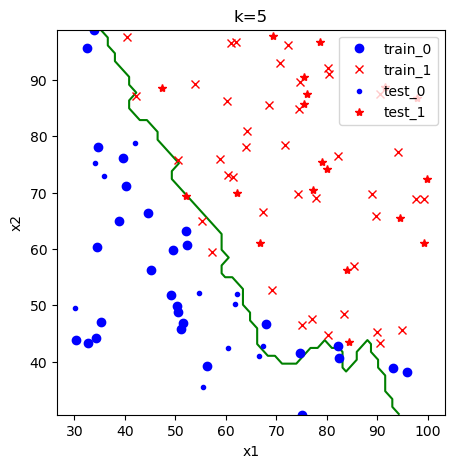

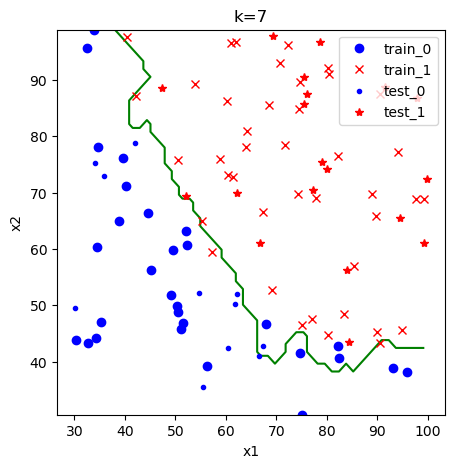

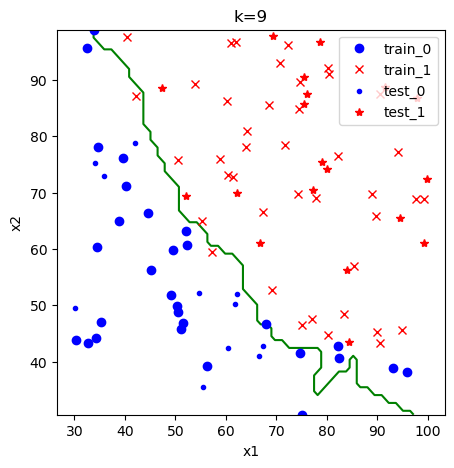

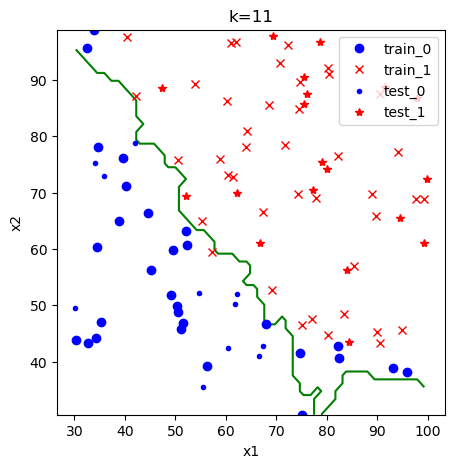

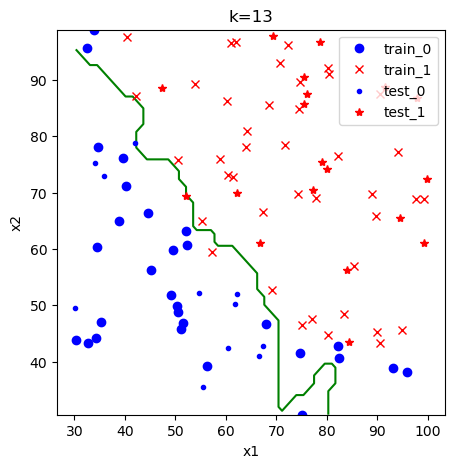

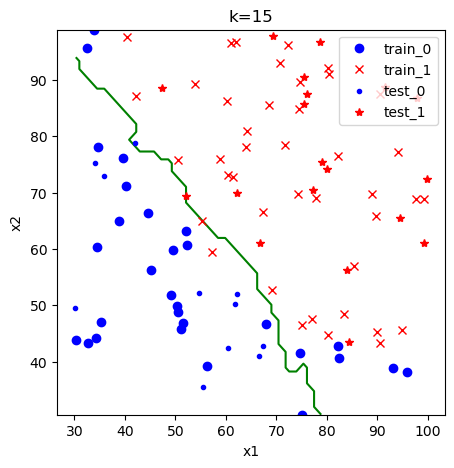

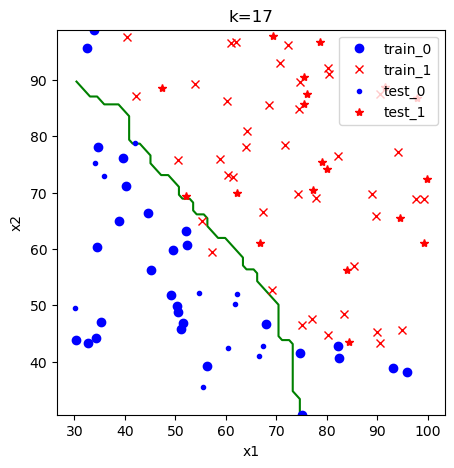

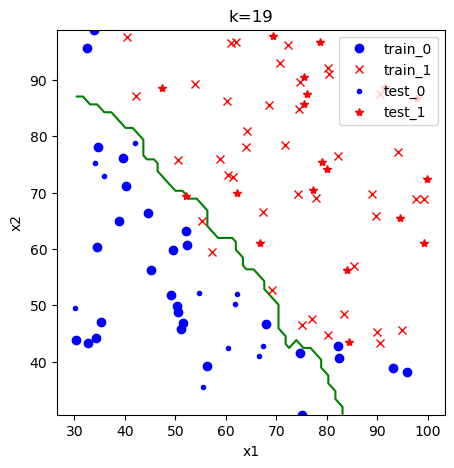

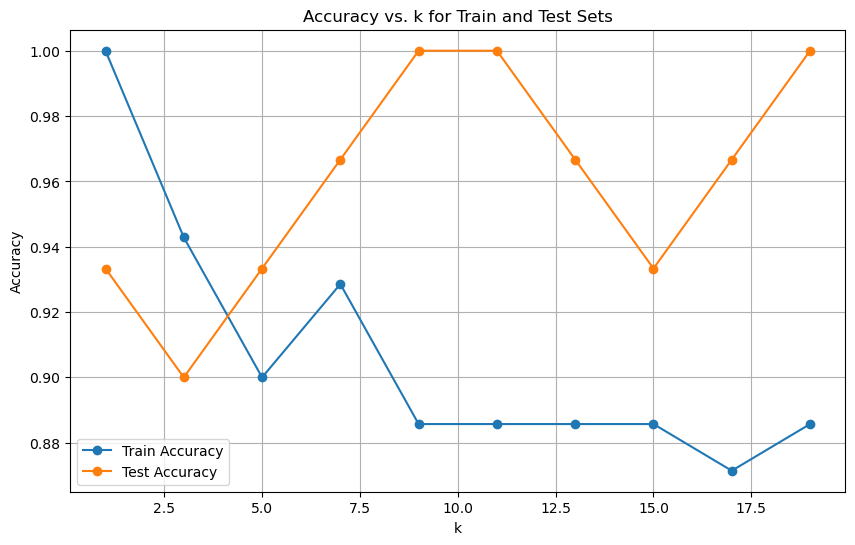

Najlepsze k: 9
Dokładność na zbiorze testowym (Accuracy): 1.0
Czułość (SE): 1.0
Pozytywne przewidywanie (PP): 1.0


In [8]:
train_accuracies = []
test_accuracies = []
best_k = None
best_test_accuracy = 0
# for k in k_values:
#     knn_classifier = KNeighborsClassifier(n_neighbors=k)
#     knn_classifier.fit(x_train, y_train)
    
#     y_train_pred = knn_classifier.predict(x_train)
#     y_test_pred = knn_classifier.predict(x_test)
#     train_accuracy = calculate_accuracy(y_train, y_train_pred)
#     test_accuracy = calculate_accuracy(y_test, y_test_pred)
#     train_accuracies.append(train_accuracy)
#     test_accuracies.append(test_accuracy)
#     if test_accuracy > best_test_accuracy:
#         best_test_accuracy = test_accuracy
#         best_k = k

x1_res = 50
x2_res = 50
x1 = np.linspace(x_train[:, 0].min(), x_train[:, 0].max(), x1_res)
x2 = np.linspace(x_train[:, 1].min(), x_train[:, 1].max(), x2_res)
x1x1, x2x2 = np.meshgrid(x1, x2)
x1x2_range_comb = np.c_[x1x1.ravel(), x2x2.ravel()]

for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(x_train, y_train)

    y_train_pred = knn_classifier.predict(x_train)
    y_test_pred = knn_classifier.predict(x_test)

    train_accuracy = calculate_accuracy(y_train, y_train_pred)
    test_accuracy = calculate_accuracy(y_test, y_test_pred)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_k = k

    labels_space = knn_classifier.predict(x1x2_range_comb).reshape(x1x1.shape)

    plt.figure(figsize=(5, 5))
    plt.title(f'k={k}')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.contour(x1x1, x2x2, labels_space, levels=[0.5], colors='g')
    plt.plot(x_train[y_train == 0, 0], x_train[y_train == 0, 1], 'bo')
    plt.plot(x_train[y_train == 1, 0], x_train[y_train == 1, 1], 'rx')
    plt.plot(x_test[y_test == 0, 0], x_test[y_test == 0, 1], 'b.')
    plt.plot(x_test[y_test == 1, 0], x_test[y_test == 1, 1], 'r*')
    plt.legend(['train_0', 'train_1', 'test_0', 'test_1'])
    plt.show()

# Wykres skuteczności względem k
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(k_values, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k for Train and Test Sets')
plt.legend()
plt.grid(True)
plt.show()

# Obliczanie SE, PP i Acc dla najlepszego k
knn_classifier_best = KNeighborsClassifier(n_neighbors=best_k)
knn_classifier_best.fit(x_train, y_train)
y_test_pred_best = knn_classifier_best.predict(x_test)
sensitivity, ppv, accuracy = calculate_sensitivity_ppv(y_test, y_test_pred_best)
print(f"Najlepsze k: {best_k}")
print(f"Dokładność na zbiorze testowym (Accuracy): {accuracy}")
print(f"Czułość (SE): {sensitivity}")
print(f"Pozytywne przewidywanie (PP): {ppv}")

# Badanie na zbiorze danych digits

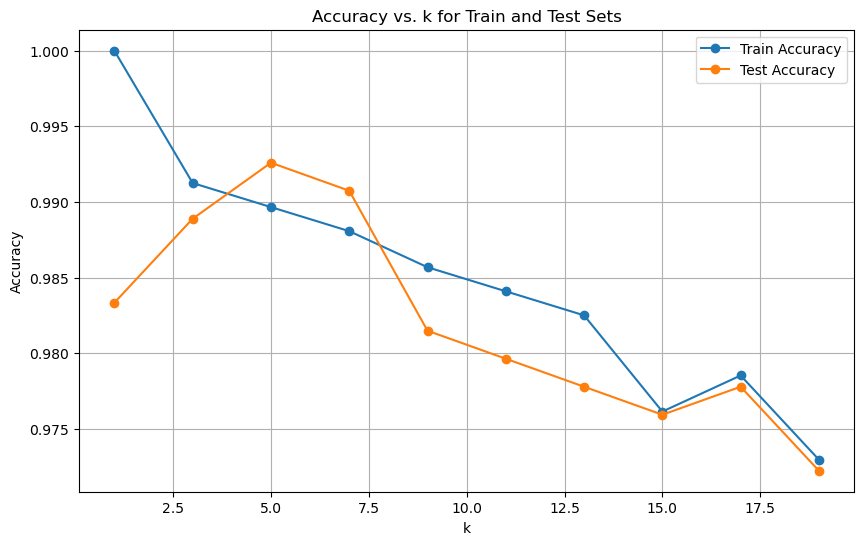

Najlepsze k: 5
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        47
           3       0.98      1.00      0.99        54
           4       0.98      1.00      0.99        60
           5       0.98      0.98      0.98        66
           6       1.00      1.00      1.00        53
           7       1.00      1.00      1.00        55
           8       1.00      1.00      1.00        43
           9       0.98      0.95      0.97        59

    accuracy                           0.99       540
   macro avg       0.99      0.99      0.99       540
weighted avg       0.99      0.99      0.99       540

Confusion Matrix:
[[53  0  0  0  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0]
 [ 0  0 47  0  0  0  0  0  0  0]
 [ 0  0  0 54  0  0  0  0  0  0]
 [ 0  0  0  0 60  0  0  0  0  0]
 [ 0  0  0  0  0 65 

In [9]:
from sklearn.datasets import load_digits
 
data = load_digits()
y = data['target']
X = data['data']

k = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

train_accuracies = []
test_accuracies = []

best_k = None
best_test_accuracy = 0

for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train, y_train)

    y_train_pred = knn_classifier.predict(X_train)
    y_test_pred = knn_classifier.predict(X_test)

    train_accuracy = np.mean(y_train_pred == y_train)
    test_accuracy = np.mean(y_test_pred == y_test)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_k = k

# Wykres skuteczności względem k
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(k_values, test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k for Train and Test Sets')
plt.legend()
plt.grid(True)
plt.show()

# Najlepszy model
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train, y_train)
y_pred_best = knn_best.predict(X_test)

# Raport i macierz konfuzji
report = classification_report(y_test, y_pred_best)
conf_matrix = confusion_matrix(y_test, y_pred_best)

print(f'Najlepsze k: {best_k}')
print(f'Classification Report:\n{report}')
print(f'Confusion Matrix:\n{conf_matrix}')

# Drzewa decyzyjne


level: 1, test acc: 0.7, train acc: 0.8428571428571429
level: 2, test acc: 0.8333333333333334, train acc: 0.9428571428571428
level: 3, test acc: 0.8333333333333334, train acc: 0.9857142857142858
level: 4, test acc: 0.8333333333333334, train acc: 1.0
level: 5, test acc: 0.8333333333333334, train acc: 1.0
level: 6, test acc: 0.8333333333333334, train acc: 1.0
level: 7, test acc: 0.8333333333333334, train acc: 1.0


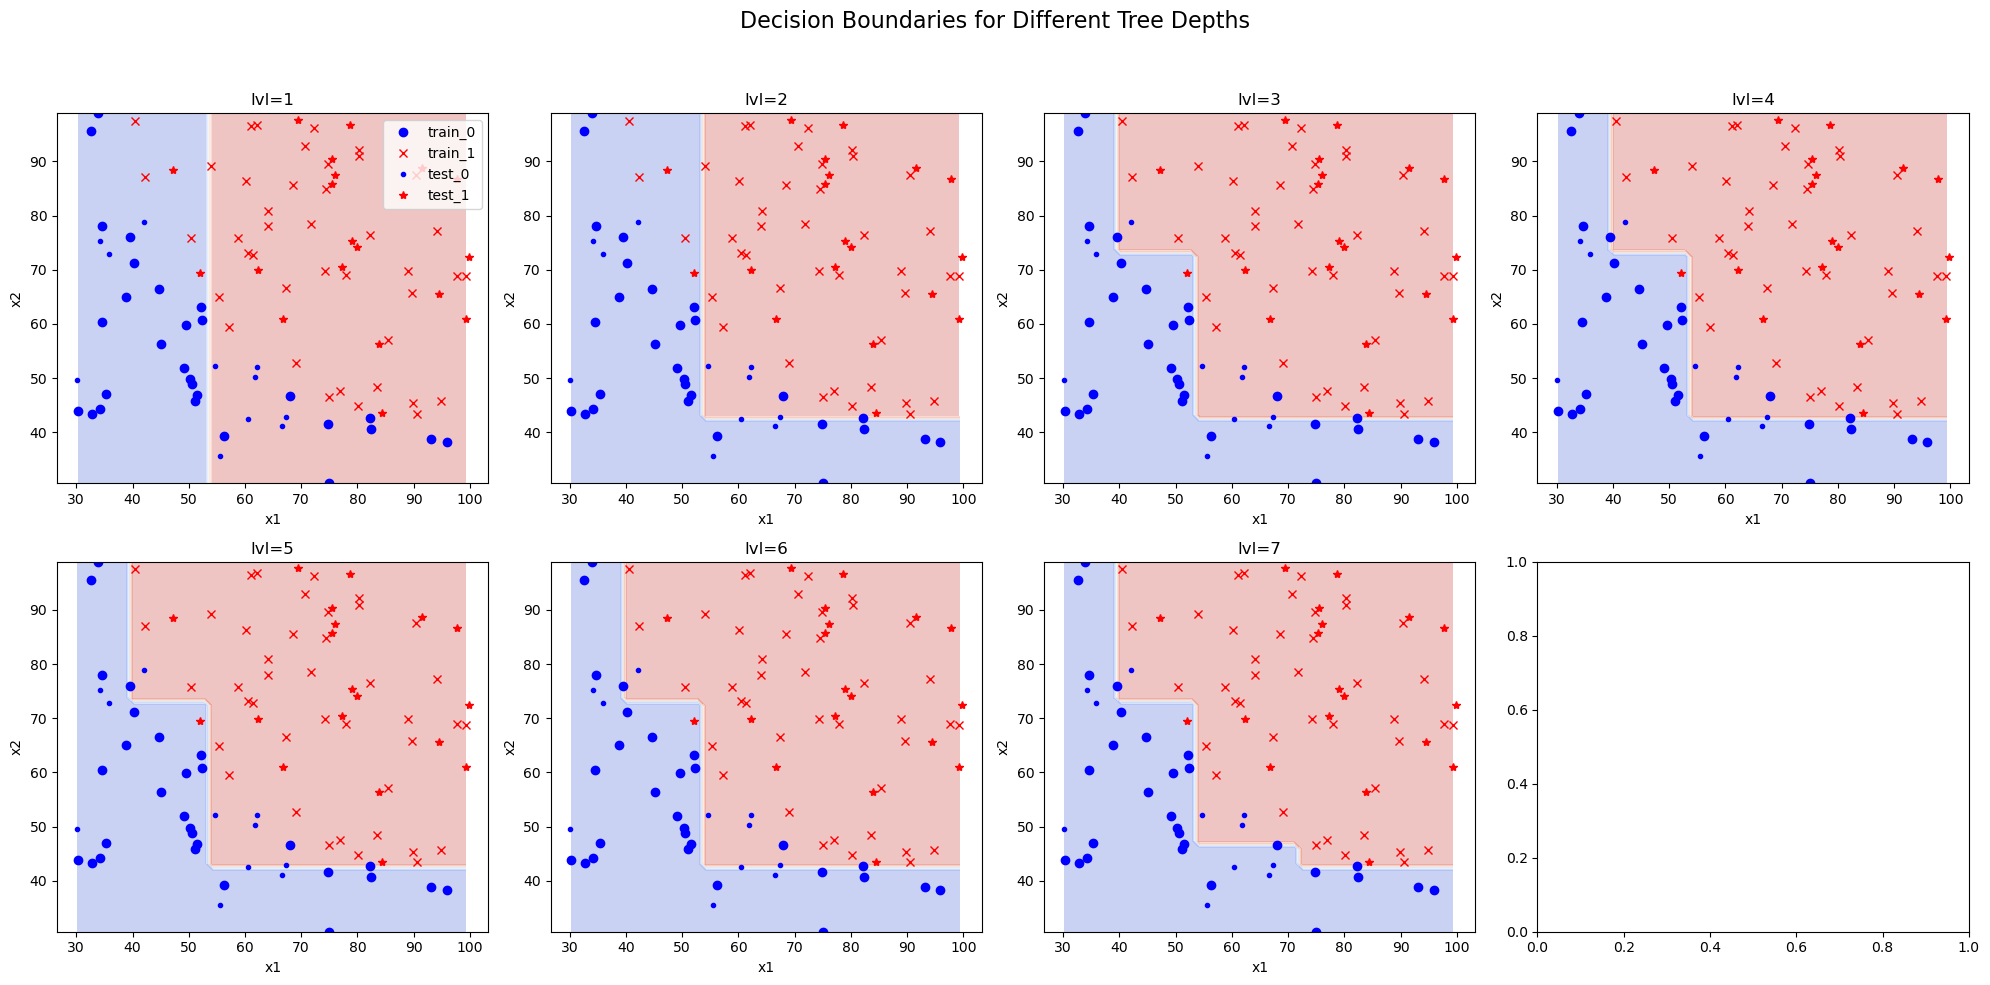

level: 1, test acc: 0.70, train acc: 0.84
level: 2, test acc: 0.83, train acc: 0.94
level: 3, test acc: 0.83, train acc: 0.99
level: 4, test acc: 0.83, train acc: 1.00
level: 5, test acc: 0.83, train acc: 1.00
level: 6, test acc: 0.83, train acc: 1.00
level: 7, test acc: 0.83, train acc: 1.00


In [ ]:
with open('./admission.txt', 'r') as f:
    reader = csv.reader(f)
    X = []
    y = []
    for row in reader:
        x1, x2, lbl = float(row[0]), float(row[1]), float(row[2])
        X.append([x1, x2])
        y.append(lbl)
X = np.array(X)
y = np.array(y)
 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lvls = [1, 2, 3, 4, 5, 6, 7]
for lvl in lvls:
  decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=lvl)
  decision_tree.fit(x_train, y_train)
  y_pred = decision_tree.predict(x_test)
  test_acc = np.sum(y_pred == y_test) / len(y_test)
  train_acc = decision_tree.score(x_train, y_train)
  print(f"level: {lvl}, test acc: {test_acc}, train acc: {train_acc}")

# Define the levels of tree depth
lvls = [1, 2, 3, 4, 5, 6, 7]

# Create subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Adjust to fit all levels
fig.suptitle('Decision Boundaries for Different Tree Depths', fontsize=16)

# Iterate over levels and axes
for idx, (lvl, ax) in enumerate(zip(lvls, axes.ravel())):
    ax.set_title(f'lvl={lvl}')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')

    # Train the decision tree
    decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=lvl)
    decision_tree.fit(x_train, y_train)

    # Prepare data for contour plot
    x1_res = 50
    x2_res = 50
    x1 = np.linspace(x_train[:, 0].min(), x_train[:, 0].max(), x1_res)
    x2 = np.linspace(x_train[:, 1].min(), x_train[:, 1].max(), x2_res)
    x1x1, x2x2 = np.meshgrid(x1, x2)
    x1x2_range_comb = np.c_[x1x1.ravel(), x2x2.ravel()]

    # Predict labels for the grid points
    labels_space = decision_tree.predict(x1x2_range_comb)
    labels_space = labels_space.reshape(x1x1.shape)

    # Plot decision boundary
    ax.contourf(x1x1, x2x2, labels_space, alpha=0.3, cmap='coolwarm')

    # Plot training set
    ax.plot(x_train[y_train == 0, 0], x_train[y_train == 0, 1], 'bo')
    ax.plot(x_train[y_train == 1, 0], x_train[y_train == 1, 1], 'rx')

    # Plot test set
    ax.plot(x_test[y_test == 0, 0], x_test[y_test == 0, 1], 'b.')
    ax.plot(x_test[y_test == 1, 0], x_test[y_test == 1, 1], 'r*')

    # Add legend only for the first subplot
    if idx == 0:
        ax.legend(['train_0', 'train_1', 'test_0', 'test_1'], loc='best')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()

# Print accuracy for each level
for lvl in lvls:
    decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=lvl)
    decision_tree.fit(x_train, y_train)
    y_pred = decision_tree.predict(x_test)
    test_acc = np.sum(y_pred == y_test) / len(y_test)
    train_acc = decision_tree.score(x_train, y_train)
    print(f"level: {lvl}, test acc: {test_acc:.2f}, train acc: {train_acc:.2f}")

In [11]:
# dla danych digits
data = load_digits()
y = data['target']
X = data['data']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

depths = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
best_depth = None
best_test_accuracy = 0

for depth in depths:
    decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=depth)
    decision_tree.fit(X_train, y_train)

    train_accuracy = decision_tree.score(X_train, y_train)
    test_accuracy = decision_tree.score(X_test, y_test)

    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_depth = depth

    print(f"Depth: {depth}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}")

# Wyświetlenie najlepszego modelu
best_tree = DecisionTreeClassifier(criterion='entropy', max_depth=best_depth)
best_tree.fit(X_train, y_train)
y_pred_best = best_tree.predict(X_test)

report = classification_report(y_test, y_pred_best)
conf_matrix = confusion_matrix(y_test, y_pred_best)

print(f'\nNajlepsza głębokość drzewa: {best_depth}')
print(f'Classification Report:\n{report}')
print(f'Confusion Matrix:\n{conf_matrix}')


Depth: 1, Train Accuracy: 0.19968178202068418, Test Accuracy: 0.18518518518518517
Depth: 3, Train Accuracy: 0.5441527446300716, Test Accuracy: 0.5055555555555555
Depth: 5, Train Accuracy: 0.8488464598249801, Test Accuracy: 0.812962962962963
Depth: 7, Train Accuracy: 0.960222752585521, Test Accuracy: 0.8685185185185185
Depth: 9, Train Accuracy: 0.9960222752585521, Test Accuracy: 0.8777777777777778
Depth: 11, Train Accuracy: 1.0, Test Accuracy: 0.8851851851851852
Depth: 13, Train Accuracy: 1.0, Test Accuracy: 0.8777777777777778
Depth: 15, Train Accuracy: 1.0, Test Accuracy: 0.8907407407407407
Depth: 17, Train Accuracy: 1.0, Test Accuracy: 0.8685185185185185
Depth: 19, Train Accuracy: 1.0, Test Accuracy: 0.8740740740740741

Najlepsza głębokość drzewa: 15
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95        53
           1       0.87      0.90      0.88        50
           2       0.91      0.89      0.90        4